In [72]:
import tensorflow as tf

all_dataset = tf.data.Dataset.list_files(
    "/nfs/general/shared/Key*/*.jpg").shuffle(buffer_size=10000)

keys_tensor = tf.constant(['KeyA', 'KeyD'])
vals_tensor = tf.constant([0, 1])
init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
table = tf.lookup.StaticHashTable(init, default_value=-1)

def CreateImageAndLabel(filename):
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image.set_shape([480, 640, 3])
    # image = tf.image.convert_image_dtype(image, tf.float32)
    labelString = tf.strings.split(filename, '/')[4]
    # label = tf.one_hot(table.lookup(labelString),2)
    return image, table.lookup(labelString)

def ExtractRoiForPrediction(image):
    x=0.3
    target_width=int(640*x)
    target_height=int(480*x)
    offset_width=(640-target_width)//2
    offset_height=(480-target_height)//2
    return tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)


# data_augmentation = lambda x: tf.image.convert_image_dtype(x, tf.float32)
data_augmentation = tf.keras.Sequential(
    [
        # tf.keras.layers.RandomRotation(0.01),
        tf.keras.layers.RandomTranslation(0.05, 0.05)
    ]
)

AUTOTUNE = tf.data.AUTOTUNE

test_dataset = all_dataset.take(250)
test_dataset = test_dataset.map(CreateImageAndLabel, num_parallel_calls=AUTOTUNE,deterministic=False)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
test_dataset = test_dataset.map(lambda x, y: (ExtractRoiForPrediction(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

train_dataset = all_dataset.skip(250)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.map(CreateImageAndLabel, num_parallel_calls=AUTOTUNE,deterministic=False)
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
train_dataset = train_dataset.map(lambda x, y: (ExtractRoiForPrediction(x), y), num_parallel_calls=AUTOTUNE, deterministic=False)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


#visualization_samples = [x for x in all_dataset.take(5).map(CreateImageAndLabel)]
# tf.profiler.experimental.stop()

# print(X.shape, y.shape)



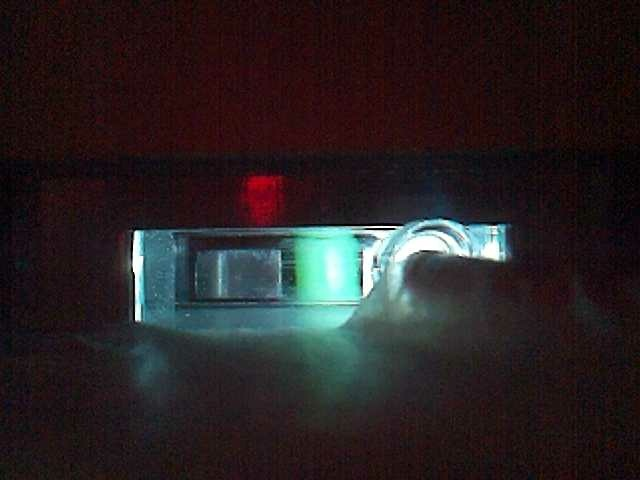
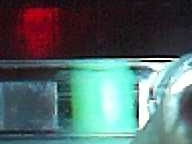
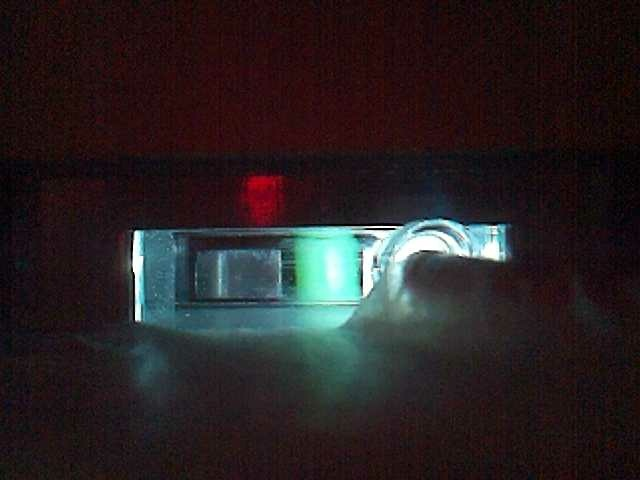

In [54]:
import base64

def BytesToImage(b):
    return "<img src=\"data:image/png;base64,"+base64.b64encode(tf.image.encode_jpeg(b).numpy()).decode('ascii') + "\">"
img=BytesToImage(visualization_samples[0][0])
img2=BytesToImage(ExtractRoiForPrediction(visualization_samples[0][0]))
img3=BytesToImage(tf.image.convert_image_dtype(data_augmentation(visualization_samples[0][0]), tf.uint8))


from IPython import display #, HTML
display.display_html(img+img2+img3, raw=True)



In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),  # 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


tb_callback = tf.keras.callbacks.TensorBoard(
    '/tmp/logs', update_freq=1, histogram_freq=1, write_images=True)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)
model.fit(train_dataset, epochs=400, steps_per_epoch=256,
          validation_data=test_dataset, callbacks=[tb_callback, model_checkpoint_callback])

tf.saved_model.save(model, '/nfs/general/shared/tf_models/color_classifier')
converter = tf.lite.TFLiteConverter.from_saved_model('/nfs/general/shared/tf_models/color_classifier') # path to the SavedModel directory
tflite_model = converter.convert()
open('/nfs/general/shared/tflite/color_classifier.tflite', 'wb').write(tflite_model)

Epoch 1/400
256/256 [==============================] - 9s 31ms/step - loss: 0.5325 - accuracy: 0.8623 - val_loss: 0.2335 - val_accuracy: 0.8520
Epoch 2/400
256/256 [==============================] - 8s 30ms/step - loss: 0.2324 - accuracy: 0.8748 - val_loss: 0.1366 - val_accuracy: 0.8640
Epoch 3/400
256/256 [==============================] - 8s 30ms/step - loss: 0.2043 - accuracy: 0.8665 - val_loss: 0.1601 - val_accuracy: 0.8760
Epoch 4/400
256/256 [==============================] - 8s 32ms/step - loss: 0.1843 - accuracy: 0.8994 - val_loss: 0.0779 - val_accuracy: 0.9760
Epoch 5/400
256/256 [==============================] - 8s 33ms/step - loss: 0.1971 - accuracy: 0.9065 - val_loss: 0.2160 - val_accuracy: 0.9360
Epoch 6/400
256/256 [==============================] - 8s 33ms/step - loss: 0.1689 - accuracy: 0.9397 - val_loss: 0.0782 - val_accuracy: 0.9960
Epoch 7/400
256/256 [==============================] - 8s 33ms/step - loss: 0.1416 - accuracy: 0.9536 - val_loss: 0.0748 - val_accuracy:

INFO:tensorflow:Assets written to: /nfs/general/shared/tf_models/color_classifier/assets
2022-04-22 07:57:12.711820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-22 07:57:12.711837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-22 07:57:12.711965: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /nfs/general/shared/tf_models/color_classifier
2022-04-22 07:57:12.714844: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-22 07:57:12.714855: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /nfs/general/shared/tf_models/color_classifier
2022-04-22 07:57:12.717999: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-22 07:57:12.756105: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /nfs/gen

232088

In [74]:
import tensorflow as tf

class FusedModel(tf.Module):
  def __init__(self):
    self.color_classifier = tf.saved_model.load('/nfs/general/shared/tf_models/color_classifier')
    self.orientation_classifier=tf.saved_model.load('/nfs/general/shared/tf_models/orientation')

  @tf.function(input_signature=[tf.TensorSpec(shape=[480,640,3], dtype=tf.uint8)])
  def compute(self, image):
    image_cropped_for_color = tf.cast(ExtractRoiForPrediction(image), tf.float32)[tf.newaxis,:,:,:]
    image_for_position_detection = tf.image.convert_image_dtype(tf.image.rgb_to_grayscale(tf.image.crop_to_bounding_box(image, 220,70,100,500)), tf.float32)[tf.newaxis,:,:,:]
    orientation=self.orientation_classifier(image_for_position_detection)[0,:]
    return tf.math.softmax(self.color_classifier(image_cropped_for_color))[0,:], orientation


model = FusedModel()
tf.saved_model.save(model, '/tmp/adder')

converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/adder') 

tflite_model = converter.convert()
open('/nfs/general/shared/tflite/fused_model.tflite', 'wb').write(tflite_model)

image = tf.io.decode_jpeg(tf.io.read_file('/nfs/general/shared/KeyD/1650406299896.jpg'))

model.compute(image)

INFO:tensorflow:Assets written to: /tmp/adder/assets


INFO:tensorflow:Assets written to: /tmp/adder/assets
2022-04-22 08:00:37.942527: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-22 08:00:37.942546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


Estimated count of arithmetic ops: 83.412 M  ops, equivalently 41.706 M  MACs


2022-04-22 08:00:37.942672: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/adder
2022-04-22 08:00:37.945749: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-22 08:00:37.945759: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/adder
2022-04-22 08:00:37.953218: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-22 08:00:38.030467: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/adder
2022-04-22 08:00:38.061765: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 119093 microseconds.
2022-04-22 08:00:38.160448: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 83.412 M  ops, equivalently 41.706 M  MACs



(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.2569803e-07, 9.9999976e-01], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.68506014, 0.6585784 ], dtype=float32)>)

In [70]:

image = tf.io.decode_jpeg(tf.io.read_file('/nfs/general/shared/KeyA/1650581627020.jpg'))

model.compute(image)

#!cat /nfs/general/shared/KeyA/1650581627020.jpg.classification

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.4601677 , 0.53983235], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8214543 , 0.67563075], dtype=float32)>)

In [ ]:
import tensorflow as tf
tf.keras.layers.preprocessing.image_preprocessing.transform
#help(tf.keras.layers.RandomZoom)

In [ ]:
from keras import backend
from keras.engine import base_layer
from keras.engine import base_preprocessing_layer
from keras.layers.preprocessing import preprocessing_utils as utils
from keras.utils import control_flow_util
import numpy as np
import tensorflow.compat.v2 as tf

H_AXIS = -3
W_AXIS = -2


def check_fill_mode_and_interpolation(fill_mode, interpolation):
  if fill_mode not in {'reflect', 'wrap', 'constant', 'nearest'}:
    raise NotImplementedError(
        'Unknown `fill_mode` {}. Only `reflect`, `wrap`, '
        '`constant` and `nearest` are supported.'.format(fill_mode))
  if interpolation not in {'nearest', 'bilinear'}:
    raise NotImplementedError('Unknown `interpolation` {}. Only `nearest` and '
                              '`bilinear` are supported.'.format(interpolation))


class RandomTranslationAndRotation(base_layer.BaseRandomLayer):
  """A preprocessing layer which randomly translates images during training.

  This layer will apply random translations to each image during training,
  filling empty space according to `fill_mode`.

  Input pixel values can be of any range (e.g. `[0., 1.)` or `[0, 255]`) and
  of interger or floating point dtype. By default, the layer will output floats.

  For an overview and full list of preprocessing layers, see the preprocessing
  [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers).

  Args:
    height_factor: a float represented as fraction of value, or a tuple of size
      2 representing lower and upper bound for shifting vertically. A negative
      value means shifting image up, while a positive value means shifting image
      down. When represented as a single positive float, this value is used for
      both the upper and lower bound. For instance, `height_factor=(-0.2, 0.3)`
      results in an output shifted by a random amount in the range
      `[-20%, +30%]`.
      `height_factor=0.2` results in an output height shifted by a random amount
      in the range `[-20%, +20%]`.
    width_factor: a float represented as fraction of value, or a tuple of size 2
      representing lower and upper bound for shifting horizontally. A negative
      value means shifting image left, while a positive value means shifting
      image right. When represented as a single positive float, this value is
      used for both the upper and lower bound. For instance,
      `width_factor=(-0.2, 0.3)` results in an output shifted left by 20%, and
      shifted right by 30%. `width_factor=0.2` results in an output height
      shifted left or right by 20%.
    fill_mode: Points outside the boundaries of the input are filled according
      to the given mode (one of `{"constant", "reflect", "wrap", "nearest"}`).
      - *reflect*: `(d c b a | a b c d | d c b a)` The input is extended by
        reflecting about the edge of the last pixel.
      - *constant*: `(k k k k | a b c d | k k k k)` The input is extended by
        filling all values beyond the edge with the same constant value k = 0.
      - *wrap*: `(a b c d | a b c d | a b c d)` The input is extended by
        wrapping around to the opposite edge.
      - *nearest*: `(a a a a | a b c d | d d d d)` The input is extended by the
        nearest pixel.
    interpolation: Interpolation mode. Supported values: `"nearest"`,
      `"bilinear"`.
    seed: Integer. Used to create a random seed.
    fill_value: a float represents the value to be filled outside the boundaries
      when `fill_mode="constant"`.

  Input shape:
    3D (unbatched) or 4D (batched) tensor with shape:
    `(..., height, width, channels)`,  in `"channels_last"` format.

  Output shape:
    3D (unbatched) or 4D (batched) tensor with shape:
    `(..., height, width, channels)`,  in `"channels_last"` format.
  """

  def __init__(self,
               height_factor,
               width_factor,
               fill_mode='reflect',
               interpolation='bilinear',
               seed=None,
               fill_value=0.0,
               **kwargs):
    base_preprocessing_layer.keras_kpl_gauge.get_cell('RandomTranslation').set(
        True)
    super(RandomTranslation, self).__init__(seed=seed, force_generator=True,
                                            **kwargs)
    self.height_factor = height_factor
    if isinstance(height_factor, (tuple, list)):
      self.height_lower = height_factor[0]
      self.height_upper = height_factor[1]
    else:
      self.height_lower = -height_factor
      self.height_upper = height_factor
    if self.height_upper < self.height_lower:
      raise ValueError('`height_factor` cannot have upper bound less than '
                       'lower bound, got {}'.format(height_factor))
    if abs(self.height_lower) > 1. or abs(self.height_upper) > 1.:
      raise ValueError('`height_factor` must have values between [-1, 1], '
                       'got {}'.format(height_factor))

    self.width_factor = width_factor
    if isinstance(width_factor, (tuple, list)):
      self.width_lower = width_factor[0]
      self.width_upper = width_factor[1]
    else:
      self.width_lower = -width_factor
      self.width_upper = width_factor
    if self.width_upper < self.width_lower:
      raise ValueError('`width_factor` cannot have upper bound less than '
                       'lower bound, got {}'.format(width_factor))
    if abs(self.width_lower) > 1. or abs(self.width_upper) > 1.:
      raise ValueError('`width_factor` must have values between [-1, 1], '
                       'got {}'.format(width_factor))

    check_fill_mode_and_interpolation(fill_mode, interpolation)

    self.fill_mode = fill_mode
    self.fill_value = fill_value
    self.interpolation = interpolation
    self.seed = seed

  def call(self, inputs, training=True):
    if training is None:
      training = backend.learning_phase()

    inputs = utils.ensure_tensor(inputs, self.compute_dtype)
    original_shape = inputs.shape
    unbatched = inputs.shape.rank == 3
    # The transform op only accepts rank 4 inputs, so if we have an unbatched
    # image, we need to temporarily expand dims to a batch.
    if unbatched:
      inputs = tf.expand_dims(inputs, 0)

    def random_translated_inputs():
      """Translated inputs with random ops."""
      inputs_shape = tf.shape(inputs)
      batch_size = inputs_shape[0]
      img_hd = tf.cast(inputs_shape[H_AXIS], tf.float32)
      img_wd = tf.cast(inputs_shape[W_AXIS], tf.float32)
      height_translate = self._random_generator.random_uniform(
          shape=[batch_size, 1],
          minval=self.height_lower,
          maxval=self.height_upper,
          dtype=tf.float32)
      height_translate = height_translate * img_hd
      width_translate = self._random_generator.random_uniform(
          shape=[batch_size, 1],
          minval=self.width_lower,
          maxval=self.width_upper,
          dtype=tf.float32)
      width_translate = width_translate * img_wd
      translations = tf.cast(
          tf.concat([width_translate, height_translate], axis=1),
          dtype=tf.float32)
      return transform(
          inputs,
          get_translation_matrix(translations),
          interpolation=self.interpolation,
          fill_mode=self.fill_mode,
          fill_value=self.fill_value)

    output = control_flow_util.smart_cond(training, random_translated_inputs,
                                          lambda: inputs)
    if unbatched:
      output = tf.squeeze(output, 0)
    output.set_shape(original_shape)
    return output

  def compute_output_shape(self, input_shape):
    return input_shape

  def get_config(self):
    config = {
        'height_factor': self.height_factor,
        'width_factor': self.width_factor,
        'fill_mode': self.fill_mode,
        'fill_value': self.fill_value,
        'interpolation': self.interpolation,
        'seed': self.seed,
    }
    base_config = super(RandomTranslation, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


def get_translation_and_rotation_matrix(translations, rotation, name=None):
  """Returns projective transform(s) for the given translation(s).

  Args:
    translations: A matrix of 2-element lists representing `[dx, dy]`
      to translate for each image (for a batch of images).
    name: The name of the op.

  Returns:
    A tensor of shape `(num_images, 8)` projective transforms which can be given
      to `transform`.
  """
  with backend.name_scope(name or 'translation_matrix'):
    num_translations = tf.shape(translations)[0]
    # The translation matrix looks like:
    #     [[1 0 -dx]
    #      [0 1 -dy]
    #      [0 0 1]]
    # where the last entry is implicit.
    # Translation matrices are always float32.
    return tf.concat(
        values=[
            tf.ones((num_translations, 1), tf.float32),
            tf.zeros((num_translations, 1), tf.float32),
            -translations[:, 0, None],
            tf.zeros((num_translations, 1), tf.float32),
            tf.ones((num_translations, 1), tf.float32),
            -translations[:, 1, None],
            tf.zeros((num_translations, 2), tf.float32),
        ],
        axis=1)


def transform(images,
              transforms,
              fill_mode='reflect',
              fill_value=0.0,
              interpolation='bilinear',
              output_shape=None,
              name=None):
  """Applies the given transform(s) to the image(s).

  Args:
    images: A tensor of shape
      `(num_images, num_rows, num_columns, num_channels)` (NHWC). The rank must
      be statically known (the shape is not `TensorShape(None)`).
    transforms: Projective transform matrix/matrices. A vector of length 8 or
      tensor of size N x 8. If one row of transforms is [a0, a1, a2, b0, b1, b2,
      c0, c1], then it maps the *output* point `(x, y)` to a transformed *input*
      point `(x', y') = ((a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k)`, where
      `k = c0 x + c1 y + 1`. The transforms are *inverted* compared to the
      transform mapping input points to output points. Note that gradients are
      not backpropagated into transformation parameters.
    fill_mode: Points outside the boundaries of the input are filled according
      to the given mode (one of `{"constant", "reflect", "wrap", "nearest"}`).
    fill_value: a float represents the value to be filled outside the boundaries
      when `fill_mode="constant"`.
    interpolation: Interpolation mode. Supported values: `"nearest"`,
      `"bilinear"`.
    output_shape: Output dimension after the transform, `[height, width]`.
      If `None`, output is the same size as input image.
    name: The name of the op.

  Fill mode behavior for each valid value is as follows:

  - reflect (d c b a | a b c d | d c b a)
  The input is extended by reflecting about the edge of the last pixel.

  - constant (k k k k | a b c d | k k k k)
  The input is extended by filling all
  values beyond the edge with the same constant value k = 0.

  - wrap (a b c d | a b c d | a b c d)
  The input is extended by wrapping around to the opposite edge.

  - nearest (a a a a | a b c d | d d d d)
  The input is extended by the nearest pixel.

  Input shape:
    4D tensor with shape: `(samples, height, width, channels)`,
      in `"channels_last"` format.

  Output shape:
    4D tensor with shape: `(samples, height, width, channels)`,
      in `"channels_last"` format.

  Returns:
    Image(s) with the same type and shape as `images`, with the given
    transform(s) applied. Transformed coordinates outside of the input image
    will be filled with zeros.

  Raises:
    TypeError: If `image` is an invalid type.
    ValueError: If output shape is not 1-D int32 Tensor.
  """
  with backend.name_scope(name or 'transform'):
    if output_shape is None:
      output_shape = tf.shape(images)[1:3]
      if not tf.executing_eagerly():
        output_shape_value = tf.get_static_value(output_shape)
        if output_shape_value is not None:
          output_shape = output_shape_value

    output_shape = tf.convert_to_tensor(
        output_shape, tf.int32, name='output_shape')

    if not output_shape.get_shape().is_compatible_with([2]):
      raise ValueError('output_shape must be a 1-D Tensor of 2 elements: '
                       'new_height, new_width, instead got '
                       '{}'.format(output_shape))

    fill_value = tf.convert_to_tensor(
        fill_value, tf.float32, name='fill_value')

    return tf.raw_ops.ImageProjectiveTransformV3(
        images=images,
        output_shape=output_shape,
        fill_value=fill_value,
        transforms=transforms,
        fill_mode=fill_mode.upper(),
        interpolation=interpolation.upper())


def get_rotation_matrix(angles, image_height, image_width, name=None):
  """Returns projective transform(s) for the given angle(s).

  Args:
    angles: A scalar angle to rotate all images by, or (for batches of images) a
      vector with an angle to rotate each image in the batch. The rank must be
      statically known (the shape is not `TensorShape(None)`).
    image_height: Height of the image(s) to be transformed.
    image_width: Width of the image(s) to be transformed.
    name: The name of the op.

  Returns:
    A tensor of shape (num_images, 8). Projective transforms which can be given
      to operation `image_projective_transform_v2`. If one row of transforms is
       [a0, a1, a2, b0, b1, b2, c0, c1], then it maps the *output* point
       `(x, y)` to a transformed *input* point
       `(x', y') = ((a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k)`,
       where `k = c0 x + c1 y + 1`.
  """
  with backend.name_scope(name or 'rotation_matrix'):
    x_offset = ((image_width - 1) - (tf.cos(angles) *
                                     (image_width - 1) - tf.sin(angles) *
                                     (image_height - 1))) / 2.0
    y_offset = ((image_height - 1) - (tf.sin(angles) *
                                      (image_width - 1) + tf.cos(angles) *
                                      (image_height - 1))) / 2.0
    num_angles = tf.shape(angles)[0]
    return tf.concat(
        values=[
            tf.cos(angles)[:, None],
            -tf.sin(angles)[:, None],
            x_offset[:, None],
            tf.sin(angles)[:, None],
            tf.cos(angles)[:, None],
            y_offset[:, None],
            tf.zeros((num_angles, 2), tf.float32),
        ],
        axis=1)


@keras_export('keras.layers.RandomRotation',
              'keras.layers.experimental.preprocessing.RandomRotation')
class RandomRotation(base_layer.BaseRandomLayer):
  """A preprocessing layer which randomly rotates images during training.

  This layer will apply random rotations to each image, filling empty space
  according to `fill_mode`.

  By default, random rotations are only applied during training.
  At inference time, the layer does nothing. If you need to apply random
  rotations at inference time, set `training` to True when calling the layer.

  Input pixel values can be of any range (e.g. `[0., 1.)` or `[0, 255]`) and
  of interger or floating point dtype. By default, the layer will output floats.

  For an overview and full list of preprocessing layers, see the preprocessing
  [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers).

  Input shape:
    3D (unbatched) or 4D (batched) tensor with shape:
    `(..., height, width, channels)`, in `"channels_last"` format

  Output shape:
    3D (unbatched) or 4D (batched) tensor with shape:
    `(..., height, width, channels)`, in `"channels_last"` format

  Attributes:
    factor: a float represented as fraction of 2 Pi, or a tuple of size 2
      representing lower and upper bound for rotating clockwise and
      counter-clockwise. A positive values means rotating counter clock-wise,
      while a negative value means clock-wise. When represented as a single
      float, this value is used for both the upper and lower bound. For
      instance, `factor=(-0.2, 0.3)` results in an output rotation by a random
      amount in the range `[-20% * 2pi, 30% * 2pi]`. `factor=0.2` results in an
      output rotating by a random amount in the range `[-20% * 2pi, 20% * 2pi]`.
    fill_mode: Points outside the boundaries of the input are filled according
      to the given mode (one of `{"constant", "reflect", "wrap", "nearest"}`).
      - *reflect*: `(d c b a | a b c d | d c b a)` The input is extended by
        reflecting about the edge of the last pixel.
      - *constant*: `(k k k k | a b c d | k k k k)` The input is extended by
        filling all values beyond the edge with the same constant value k = 0.
      - *wrap*: `(a b c d | a b c d | a b c d)` The input is extended by
        wrapping around to the opposite edge.
      - *nearest*: `(a a a a | a b c d | d d d d)` The input is extended by the
        nearest pixel.
    interpolation: Interpolation mode. Supported values: `"nearest"`,
      `"bilinear"`.
    seed: Integer. Used to create a random seed.
    fill_value: a float represents the value to be filled outside the boundaries
      when `fill_mode="constant"`.
  """

  def __init__(self,
               factor,
               fill_mode='reflect',
               interpolation='bilinear',
               seed=None,
               fill_value=0.0,
               **kwargs):
    base_preprocessing_layer.keras_kpl_gauge.get_cell('RandomRotation').set(
        True)
    super(RandomRotation, self).__init__(seed=seed, force_generator=True,
                                         **kwargs)
    self.factor = factor
    if isinstance(factor, (tuple, list)):
      self.lower = factor[0]
      self.upper = factor[1]
    else:
      self.lower = -factor
      self.upper = factor
    if self.upper < self.lower:
      raise ValueError('Factor cannot have negative values, '
                       'got {}'.format(factor))
    check_fill_mode_and_interpolation(fill_mode, interpolation)
    self.fill_mode = fill_mode
    self.fill_value = fill_value
    self.interpolation = interpolation
    self.seed = seed

  def call(self, inputs, training=True):
    if training is None:
      training = backend.learning_phase()

    inputs = utils.ensure_tensor(inputs, self.compute_dtype)
    original_shape = inputs.shape
    unbatched = inputs.shape.rank == 3
    # The transform op only accepts rank 4 inputs, so if we have an unbatched
    # image, we need to temporarily expand dims to a batch.
    if unbatched:
      inputs = tf.expand_dims(inputs, 0)

    def random_rotated_inputs():
      """Rotated inputs with random ops."""
      inputs_shape = tf.shape(inputs)
      batch_size = inputs_shape[0]
      img_hd = tf.cast(inputs_shape[H_AXIS], tf.float32)
      img_wd = tf.cast(inputs_shape[W_AXIS], tf.float32)
      min_angle = self.lower * 2. * np.pi
      max_angle = self.upper * 2. * np.pi
      angles = self._random_generator.random_uniform(
          shape=[batch_size], minval=min_angle, maxval=max_angle)
      return transform(
          inputs,
          get_rotation_matrix(angles, img_hd, img_wd),
          fill_mode=self.fill_mode,
          fill_value=self.fill_value,
          interpolation=self.interpolation)

    output = control_flow_util.smart_cond(training, random_rotated_inputs,
                                          lambda: inputs)
    if unbatched:
      output = tf.squeeze(output, 0)
    output.set_shape(original_shape)
    return output

  def compute_output_shape(self, input_shape):
    return input_shape

  def get_config(self):
    config = {
        'factor': self.factor,
        'fill_mode': self.fill_mode,
        'fill_value': self.fill_value,
        'interpolation': self.interpolation,
        'seed': self.seed,
    }
    base_config = super(RandomRotation, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))
